In [1]:
from pyquil.quil import *
from pyquil.api import get_qc
from pyquil.gates import *
from pyquil.latex import display, to_latex
from pyquil.simulation.tools import lifted_gate, program_unitary, lifted_gate_matrix

In [2]:
from pyquil.simulation.tools import lifted_gate, program_unitary, lifted_gate_matrix

In [31]:
from functions import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
qc = get_qc("9q-square-qvm")

40


# Programmable recipe
![alt text](rotation_definition.png "Title")
$$R(\theta, \phi) = R_z(-\frac{\phi}{2})R_y(\theta)R_z(\frac{\phi}{2})$$
![alt text](programmble_decomposition.png "Title")

In [10]:
G = Program(PHASE(- np.pi/2, qubit=0), CNOT(control=0, target=1))

$$R(\theta, \phi) = R_z(-\frac{\phi}{2})R_y(\theta)R_z(\frac{\phi}{2})\\
U(2) = R(\theta, \phi) R_z(\phi_z)\\
or\\
U(2) = R_z(\theta) R_y(\phi) R_z(\psi)
$$

In [11]:
def arbitary_single_qubit_circuit(theta, phi, si, qubit):
    return Program( RZ(si, qubit = qubit), RY(phi, qubit = qubit), RZ(theta, qubit = qubit) )

def r_theta_phi_rotation(theta, phi, qubit):
    return arbitary_single_qubit_circuit( - phi/2, theta, phi/2, qubit)

In [12]:
def give_random_single_qubit_gate(qubit):
    theta, si = np.random.uniform(0,2*np.pi, size = 2)
    
    phi_range = np.linspace(0,np.pi)
    p_phi = np.sin(phi_range) / np.sum(np.sin(phi_range))
    phi = np.random.choice(phi_range, p = p_phi)
    return arbitary_single_qubit_circuit(theta, phi, si, qubit = qubit)

def normalized_abs_angle_dist(angle_range):
    dist = np.pi - np.abs( np.pi - angle_range )
    dist /= np.sum(dist)
    return dist

def give_random_two_quibt_circuit(qubits):
    a,b,c,d = [give_random_single_qubit_gate(qubit=qubit) for _ in range(2) for qubit in qubits]
    
    angles_range = np.linspace(0,2*np.pi)
    alpha, beta, delta = np.random.choice(angles_range, p = normalized_abs_angle_dist(angles_range),
                                          size = 3)
    
    prog = Program(a, b )
    prog += Program(G,  r_theta_phi_rotation(alpha, 0, qubit =0), 
                    r_theta_phi_rotation(3*np.pi/2,0, qubit =1), G)
    prog += Program( r_theta_phi_rotation(beta, np.pi/2, qubit = 0), 
                    r_theta_phi_rotation(3*np.pi/2, delta, qubit = 1), G)
    prog += Program(c, d )
    return prog

In [13]:
program_unitary(give_random_two_quibt_circuit([0,1]), n_qubits=2)

array([[ 0.19845562-0.26609277j, -0.03706412-0.76244361j,
         0.13176948-0.42168488j,  0.16538687+0.29082958j],
       [ 0.00080128+0.00432686j,  0.11983061-0.50759074j,
        -0.48980122+0.69482438j, -0.04522275-0.05693554j],
       [ 0.29467658+0.51689606j, -0.27298188+0.11801172j,
        -0.24059637+0.01466111j, -0.04967811+0.70496016j],
       [ 0.4877318 +0.5457953j , -0.14434488-0.1897813j ,
         0.0135955 -0.15442189j,  0.06399648-0.61582976j]])

In [14]:
sample = give_random_two_quibt_circuit([0,1])
print( qc.compile( sample ) , len(sample), len(qc.compile( sample )))

RZ(2.3549483314662356) 0
RX(pi/2) 0
RZ(1.2696260630272374) 0
RX(-pi/2) 0
RZ(0.43283960912001485) 0
RZ(-0.9644991137808495) 1
RX(pi/2) 1
RZ(1.3942960673353695) 1
RX(-pi/2) 1
RZ(3.3115992459794157) 1
XY(pi) 0 1
RZ(-pi) 0
RX(pi/2) 0
RZ(2.885322828378827) 0
RX(-pi/2) 0
RZ(pi/2) 0
RZ(pi/2) 1
RX(pi/2) 1
RZ(pi/2) 1
RX(-pi/2) 1
RZ(-1.9820181086288757) 1
XY(pi) 0 1
RX(pi/2) 0
RZ(pi/2) 0
RX(-pi/2) 0
RX(pi/2) 1
RZ(1.437791777911901) 1
RX(-pi/2) 1
XY(pi) 0 1
RZ(1.958376828831347) 0
RX(pi/2) 0
RZ(0.32188007374616506) 0
RX(-pi/2) 0
RZ(1.404010229601675) 0
RZ(1.1543662481328698) 1
RX(pi/2) 1
RZ(1.0106482751416135) 1
RX(-pi/2) 1
RZ(-1.1584399956892482) 1
HALT
 30 39


# Visualization
## single-qubit

In [16]:
num_samples = 2021

single_qubit_unitary_samples = [program_unitary(give_random_single_qubit_gate(qubit=0), n_qubits = 1) for _ in range(num_samples)]

In [17]:
single_zero_state_density_matrix = np.array([[1,0],[0,0]])
single_final_states = np.array( [np.dot( np.dot(u,single_zero_state_density_matrix), u.conj().T ) for u in single_qubit_unitary_samples] )

In [19]:
single_qubit_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in single_final_states])

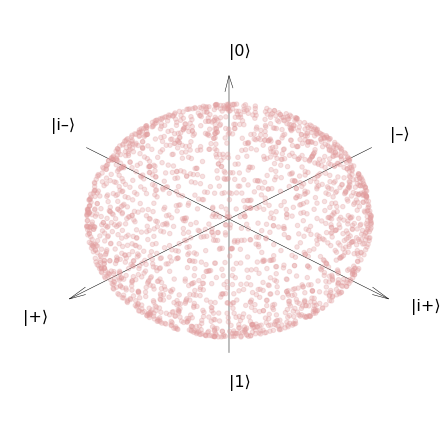

In [20]:
plot_bloch_sphere(single_qubit_bloch_vectors)

## Two qubits

In [21]:
num_samples = 2021

two_qubit_unitary_samples = [program_unitary(give_random_two_quibt_circuit([0,1]), n_qubits = 2) for _ in range(num_samples)]

In [22]:
two_zero_state_density_matrix = np.kron( np.array([[1,0],[0,0]]) , np.array([[1,0],[0,0]]) )
two_final_states = np.array( [np.dot( np.dot(u,two_zero_state_density_matrix), u.conj().T ) for u in two_qubit_unitary_samples] )

In [35]:
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.eye(2)

two_qubit_unitary_basis = np.array([ [ np.kron(x,y) for x in [X,Y,Z] ] for y in [X,Y,Z] ])
# two_qubit_unitary_basis[0]

In [36]:
# Used the mixed state simulator so we could have the density matrix for this part!
def reduce_to_bloch_vector(rho, sigma_arr:np.array):
    """Reduce a density matrix to a Bloch vector."""
    ax = np.trace(np.dot(rho, sigma_arr[0])).real
    ay = np.trace(np.dot(rho, sigma_arr[1])).real
    az = np.trace(np.dot(rho, sigma_arr[2])).real
    return [ax, ay, az]

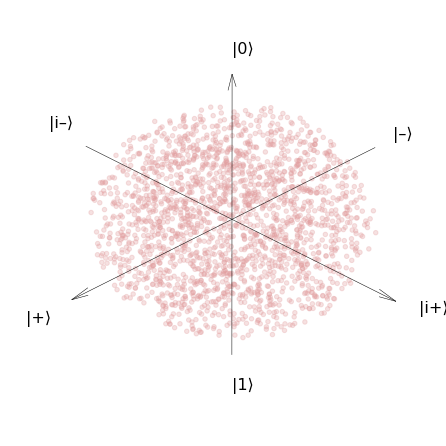

In [44]:
two_qubit_bloch_vectors = np.array([reduce_to_bloch_vector(s,two_qubit_unitary_basis[2]) for s in two_final_states])
plot_bloch_sphere(two_qubit_bloch_vectors)

In [45]:
r_bloch_vectors = np.sqrt( two_qubit_bloch_vectors[:,0]**2 + two_qubit_bloch_vectors[:,1]**2 + two_qubit_bloch_vectors[:,2]**2)

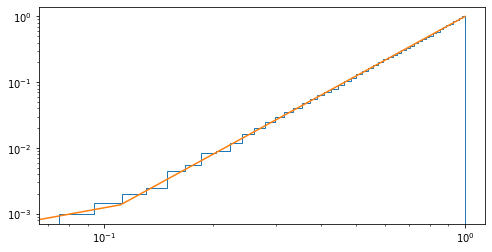

In [46]:
n_bins = 50

fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
ax.hist(r_bloch_vectors, n_bins, density=True, histtype='step',
         cumulative=True, label='Empirical')
ax.set_yscale('log')
ax.set_xscale('log')
ax.plot(np.linspace(0,1,10), np.linspace(0,1,10)**3)
plt.show()

# Rotation recipe
[alt text](rotation_decomposition.png "Title")

In [30]:
# def arbitary_single_quibt_circuit(theta, phi, si, qubit):
#     return Program( RZ(theta, qubit = qubit), RY(phi, qubit = qubit), RZ(si, qubit = qubit) )

# def give_random_single_qubit_gate(qubit):
#     theta, si = np.random.uniform(0,2*np.pi, size = 2)
    
#     phi_range = np.linspace(0,np.pi)
#     p_phi = np.sin(phi_range) / np.sum(np.sin(phi_range))
#     phi = np.random.choice(phi_range, p = p_phi)
#     return arbitary_single_quibt_circuit(theta, phi, si, qubit = qubit)

# def give_random_two_quibt_circuit(qubits):
#     a,b,c,d = [give_random_single_qubit_gate(qubit=qubit) for _ in range(2) for qubit in qubits]

#     alpha, beta, delta = np.random.uniform(0,2*np.pi, size = 3)
    
#     prog = Program(c, d )
#     prog += Program( CNOT(control = qubits[0], target=qubits[1]), RZ(delta, qubit=qubits[0]), RY(beta, qubit=qubits[1]) )
#     prog += Program( CNOT(control = qubits[1], target = qubits[0]), RY(alpha, qubit=qubits[1]), CNOT(control = qubits[0], target=qubits[1]) )
#     prog += Program(a, b )
#     return prog